In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm.notebook import trange
import pickle

In [ ]:
mean = 0.13
std = 0.02

In [32]:
np.random.lognormal(0,1)

3.056185265582882

In [179]:
def multi_species_model(p,t,  n , Gamma, sigma, mu):
    """
    Simulate a multispecies model of community growth. 
    
    Parameters
    ----------
    n: int
        The number of species to simulate
    
    Gamma: n x n np.array
        A matrix of the interaction terms where the ij-th term models the interaction
        strength of the ij-th species
    
    Sigma: n np.array
        A vector of the intrinsic external growth effect, generally set to a constant
    
    mu: n np.array
        A vector of the intrinsic growth rates of the bacteria
        
    p: n np.array
        A vector of the initial species distribution.
    """
    
    # We must construct a list of n elements, each corresponding to the growth derivative of each species
    dpdt = np.zeros(n)
    
    # Pull off all positive interactions and negative interactions
    Gamma_pos = Gamma*(Gamma > 0)
    Gamma_neg = Gamma*(Gamma < 0)
    
    # Compute the current value of the net positive and negative interaction terms
    gamma_pos = Gamma_pos @ p
    gamma_neg = Gamma_neg @ p
    

    dpdt = mu * p * ( np.ones(n) - p - sigma/(np.ones(n)+gamma_pos)  + gamma_neg )
    return dpdt

In [180]:
def random_parameters(n, int_mean, int_width, growth_mean, growth_var):
    # Generate simulation parameters
    time_range = np.linspace(0,2000,134)
    Gamma = int_width*np.random.randn(n,n) + int_mean*np.ones((n,n))
    sigma = 0.05*np.ones(n)
    mu = growth_mean*np.ones(n) + growth_var*np.random.randn(n)
    p_0 = 0.05*np.ones(n)
    
    return time_range, Gamma, sigma, mu, p_0

In [181]:
n = 7 # Small community size
int_mean = 1 # Mean interaction term \gamma_ij
int_width = 0.2 # Std of \gamma_ij
growth_var = 0.02 # variance of basal growth rate \mu_i
growth_mean = 1.0 / 250.0 # mean of basal growth rate \mu_j

(134, 7)


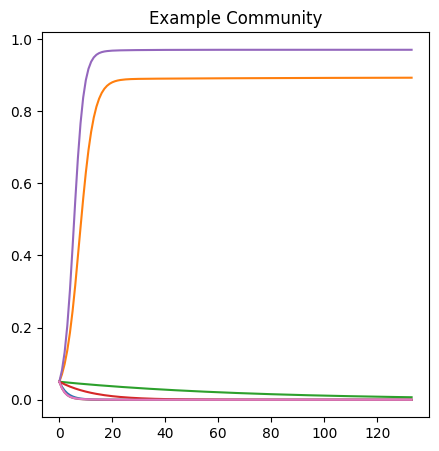

In [186]:
# Generate simulation paramters
params = random_parameters(n, mean, int_width, growth_mean, growth_var)
time_range, Gamma, sigma, mu, p_0  = params

# Integrate
sol = odeint(multi_species_model, p_0, time_range, args = (n,Gamma, sigma, mu, ))
print(sol.shape)
# Plote solution
plt.figure(figsize = (5,5))
plt.title("Example Community")
plt.plot(sol)
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

(30569, 134)


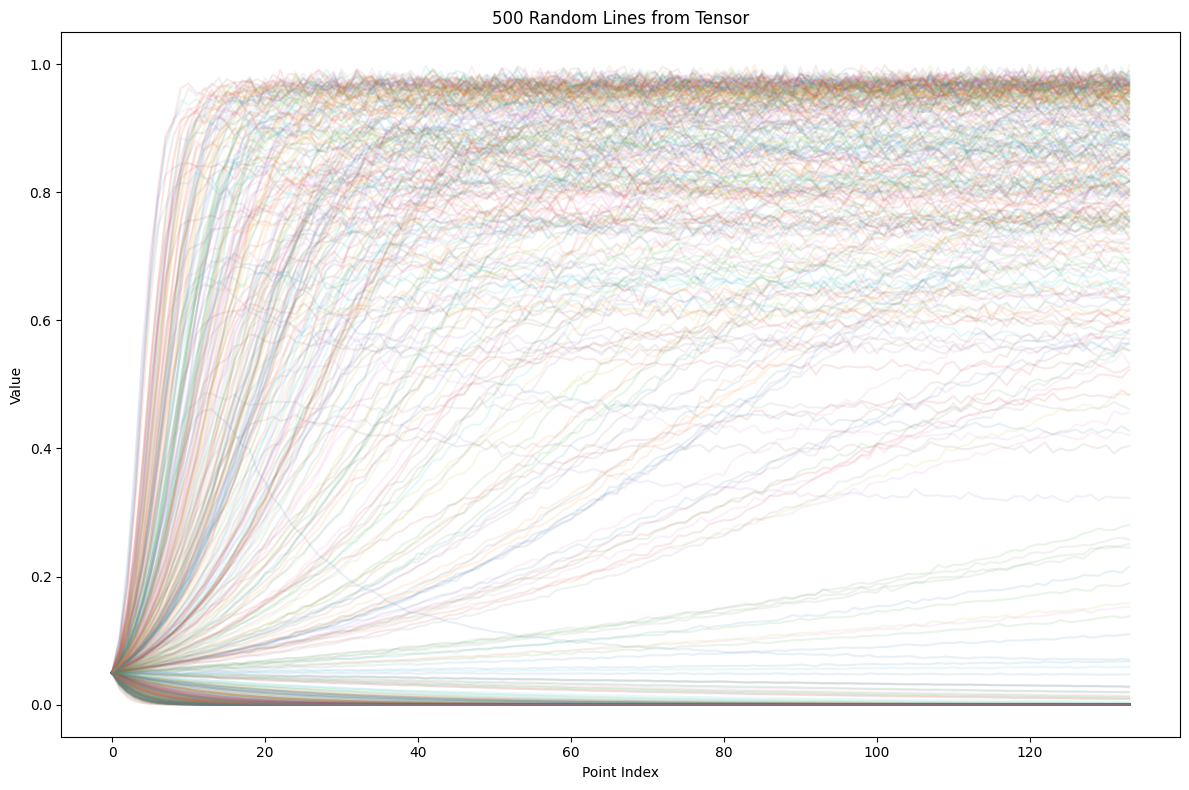

In [244]:
n = 7

np.random.seed(73)

sim_lists = []
for i in trange(5000):
    
    # Roll new parameters
    params = random_parameters(n, mean, int_width, growth_mean, growth_var)
    time_range, Gamma, sigma, mu, p_0, = params

    # Integrate
    sol = odeint(multi_species_model, p_0, time_range, args = (n,Gamma, sigma, mu,))
    # Add valid growth curves to the growing list. 

    shape = sol.shape
    noise = np.random.lognormal(mean=0, sigma=0.01, size=shape)
    
    # Center the noise around 1
    centered_noise = noise / np.exp(sigma**2 / 2)
    
    # Multiply the original tensor by the centered noise
    sol = sol * centered_noise

    if np.isnan(sol).any():
        pass
    elif sol[sol > 1.0].any():
        pass
    else:
        sim_lists.append(sol)
    #sim_lists.append(sol)
    
    #sim_lists.append(sol)
    '''for i in range(sol.shape[1]):
        # Make sure we drop any integrals resulting from outside the [0,1.0] domain
        if np.isnan(sol[:,i]).any():
            pass
        elif sol[sol > 1.0].any():
            pass
        else:
            # Take the finite difference to estimate the derivative. 
            #sim_lists.append(np.diff(sol[:,i]))
            # sim_lists.append(sol[:,i])
            sim_lists.append(sol)'''

sols = np.array(sim_lists).transpose(0,2,1)
sols = sols.reshape(-1, 134)
print(sols.shape)
random_indices = np.random.choice(1000, 500, replace=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each selected line
for idx in random_indices:
    line = sols[idx]
    ax.plot(line, alpha=0.1)

# Customize the plot
ax.set_xlabel('Point Index')
ax.set_ylabel('Value')
ax.set_title('500 Random Lines from Tensor')


# Show the plot
plt.tight_layout()
plt.show()

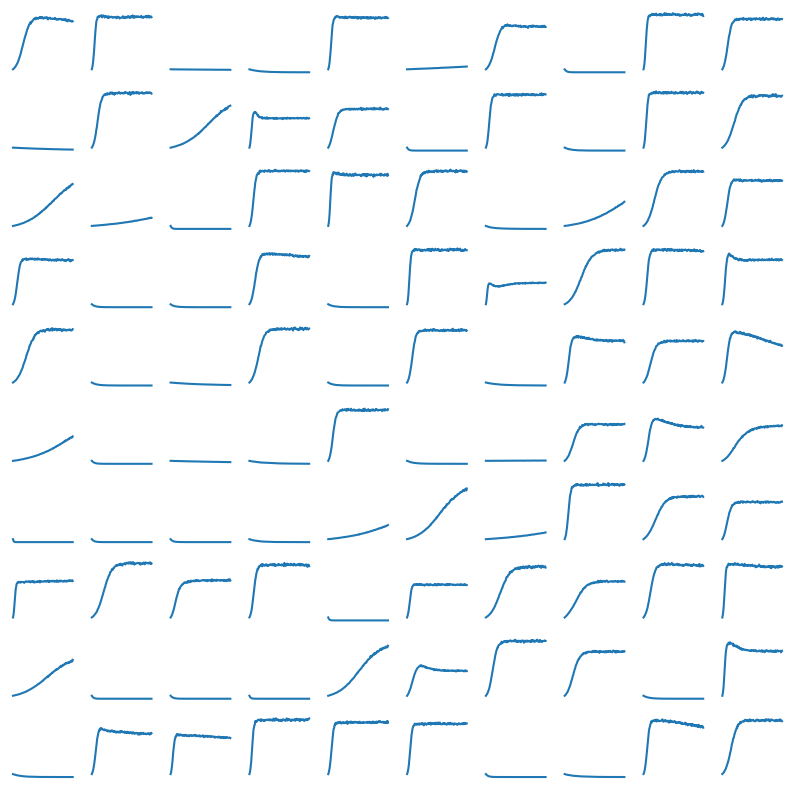

In [245]:
fig, axs = plt.subplots(10,10, figsize = (10,10), sharex = True, sharey = True)
axs = axs.flatten()

# Choose 100 curves at random and plot them
A = sols[np.random.randint(sols.shape[0],size = 100),:]
for i in range(100):
    axs[i].plot(A[i])
    axs[i].axis("off")
plt.show()

In [246]:
output = open('noisy_data.pkl', 'wb')
pickle.dump(sols, output)
output.close()

2